In [1]:
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_
from pathlib import Path
from tqdm import tqdm

from src.ImUtils import *
from src.Segmentation3D import *
from src.PlottingFunctions import *
from src.CellSegmentation import *
from src.HolomonitorFunctions import *
from src.FormatConversions import import_holomonitor_stack, import_tomocube_stack


In [2]:
vox_to_um = get_voxel_size_35mm()
pix_to_um = get_pixel_size()

52


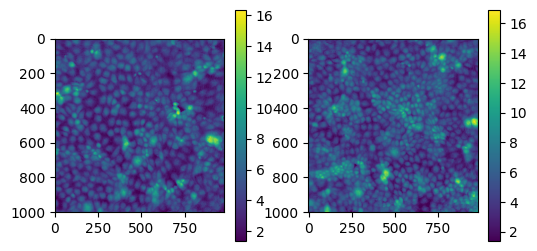

In [3]:
# Holomonitor
file = "A1-18"
folder = "../data/Holomonitor/MDCK_19.03.2024/"
fmin=130
fmax=181
im = import_holomonitor_stack(folder, file, f_min=fmin, f_max=fmax)


# # Tomocube
# fmin = 1
# fmax = 40
# file = "250611.151310.MDCK-parental.001.1per7_5.B3.T001P02"
# folder = "../data/Tomocube/MDCK_11.06.2025/B3P2"
# im, _ = import_tomocube_stack(folder, file, vox_to_um[0], f_min=fmin, f_max=fmax)


fig, ax = plt.subplots(1,2, figsize=(6, 3))
im0 = ax[0].imshow(im[0],  vmin=1.37)
im1 = ax[1].imshow(im[-1], vmin=1.37)

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
print(len(im))

#im = im[:, 250:750, 250:750]

(1004, 977)


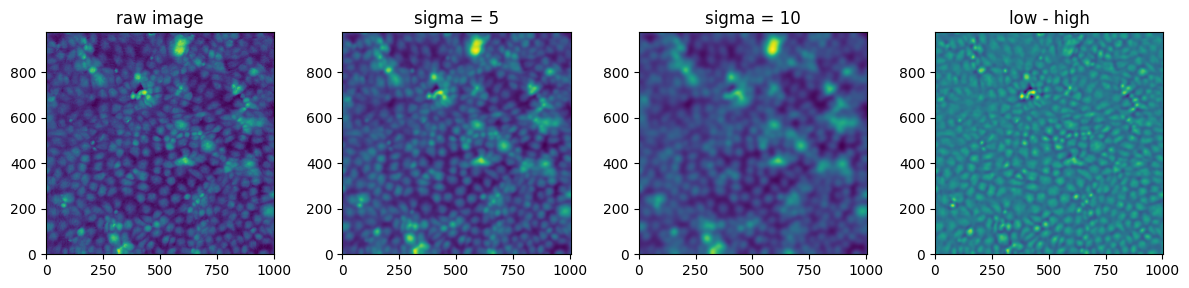

In [4]:
idx = 0
s_low_tmp  = 5
s_high_tmp = 10#1.1*s_low_tmp

n_gauss = smoothen_normalize_im(im[idx], s_low_tmp, s_high_tmp, fig=True)
print(np.shape(n_gauss))

547


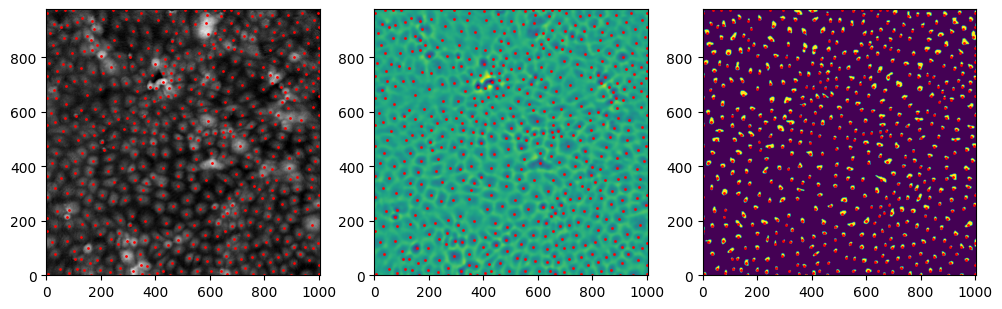

In [5]:
H_tmp = 0.03
hmin = extendedmin(-n_gauss, H_tmp)
pos_idx = find_cell_pos(-n_gauss, H_tmp)

fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].imshow(im[idx].T, cmap="gray", origin="lower", vmin=1.37)
ax[0].plot(*pos_idx.T, 'r.', ms=2)

ax[1].imshow(-n_gauss.T, origin="lower")
ax[1].plot(*pos_idx.T, 'r.', ms=2)

ax[2].imshow(hmin.T, origin="lower")
ax[2].plot(*pos_idx.T, 'r.', ms=2)

print(len(pos_idx))

547


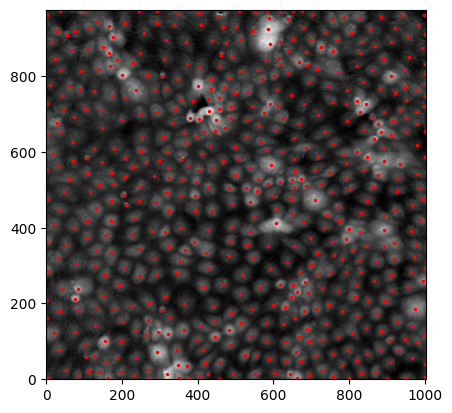

In [6]:
plt.imshow(im[idx].T, cmap="gray", origin="lower", vmin=1.37)

plt.plot(*pos_idx.T, 'r.', ms=3)
print(len(pos_idx))

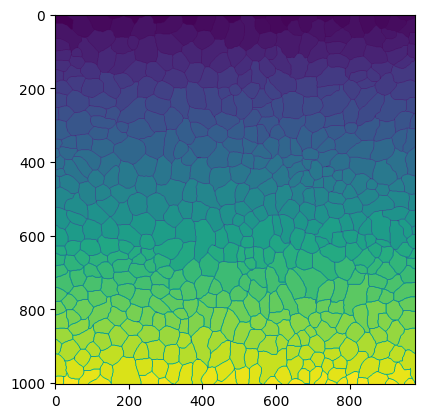

In [7]:
n_gauss = smoothen_normalize_im(im[idx], 5, 10, fig=False)
seeds   = generate_seed_mask(pos_idx, n_gauss.shape)
areas   = watershed(-n_gauss, seeds, watershed_line=True)

plt.imshow(areas)

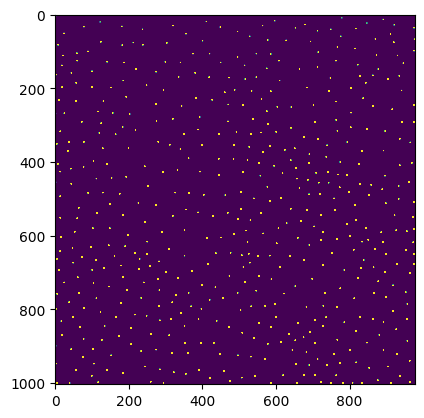

In [64]:
seeds   = generate_seed_mask(pos_idx, n_gauss.shape)
np.array(seeds, dtype=np.int16)
plt.imshow(seeds, vmax=1)

In [25]:
n_gauss = smoothen_normalize_im(im[idx], 5, 10, fig=False)
areas, edges = get_cell_areas(-n_gauss, pos_idx, im[idx], clear_edge=False)
new_pos = update_pos(pos_idx, areas)

fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].imshow(im[idx].T, origin="lower", vmin=1.37)
ax[0].plot(*pos_idx.T, 'r.')
ax[0].plot(*new_pos.T, 'k.')

ax[1].imshow(((areas>0)*im[idx]).T, origin="lower")
ax[1].plot(*pos_idx.T, 'ro')
ax[1].plot(*new_pos.T, 'k.')
print(np.sum(new_pos.T[0]>0))

TypeError: No matching signature found

In [24]:
def get_cell_areas(im, pos, h_im, clear_edge=True):
    '''
    Uses watershed to obtain mask of labeled cell areas
    '''

    # get cell areas with watershed
    seeds = generate_seed_mask(pos, im.shape)
    areas = watershed(im, seeds, watershed_line=False, connectivity=1)
    edges = watershed(im, seeds, watershed_line=True)

    # remove empty areas
    cell_mask = (h_im > 0)
    cell_areas = areas*cell_mask

    # remove small holes and areas
    #cell_areas = morph.remove_small_holes(cell_areas, area_threshold=100)

    if clear_edge:
        cell_areas = clear_border(cell_areas)

    cell_edges = (edges == 0)

    return cell_areas, cell_edges

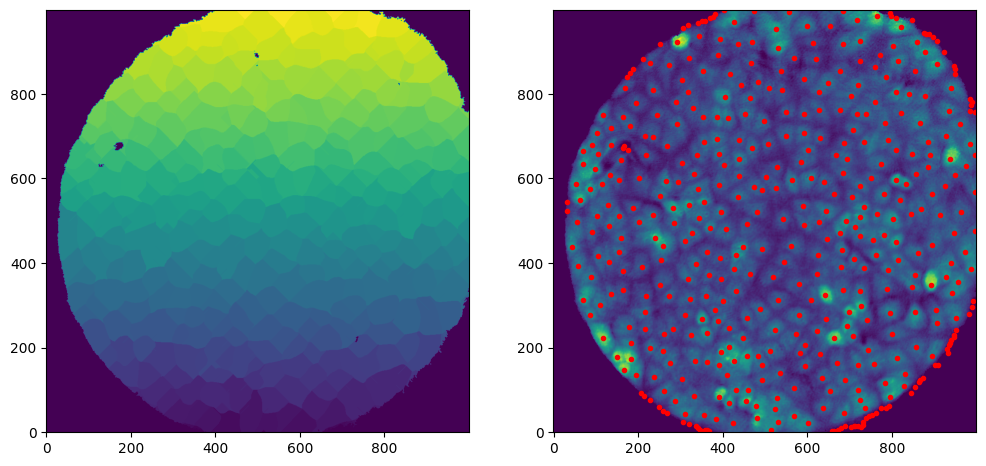

In [31]:
test = im[idx].T[:1000, :1000]

s_low_tmp = 5
s_high_tmp = 10#1.1*s_low_tmp
n_gauss = smoothen_normalize_im(test, s_low_tmp, s_high_tmp, fig=False)
H_tmp = 0.03
hmin = extendedmin(-n_gauss, H_tmp)
pos_idx = find_cell_pos(-n_gauss, H_tmp)
n_gauss = smoothen_normalize_im(test, 10, 15, fig=False)
areas, edges = get_cell_areas(-n_gauss, pos_idx, test, clear_edge=False)
new_pos = update_pos(pos_idx, areas)


fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(areas, origin="lower")
ax[1].imshow(im[idx].T[:1000, :1000], origin="lower")
ax[1].plot(pos_idx.T[1], pos_idx.T[0], 'r.')

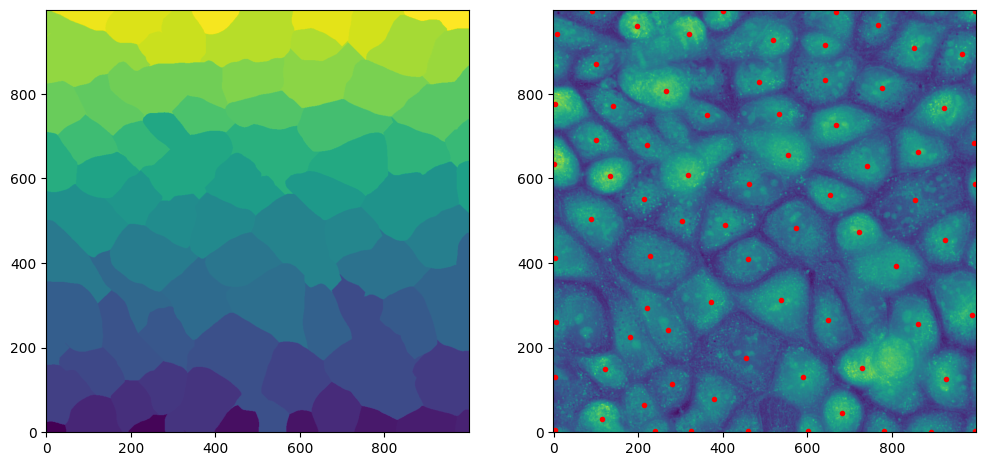

In [24]:
test = im[idx].T[:1000, :1000]

s_low_tmp = 30
s_high_tmp = 33#1.1*s_low_tmp
n_gauss = smoothen_normalize_im(test, s_low_tmp, s_high_tmp, fig=False)
H_tmp = 0.01
hmin = extendedmin(-n_gauss, H_tmp)
pos_idx = find_cell_pos(-n_gauss, H_tmp)
n_gauss = smoothen_normalize_im(test, 10, 15, fig=False)
areas, edges = get_cell_areas(-n_gauss, pos_idx, test, clear_edge=False)
new_pos = update_pos(pos_idx, areas)


fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(areas, origin="lower")
ax[1].imshow(im[idx].T[:1000, :1000], origin="lower")
ax[1].plot(pos_idx.T[1], pos_idx.T[0], 'r.')